In [2]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Loading the Dataset

In [3]:
datasets = load_dataset('financial_phrasebank', 'sentences_allagree', split='train').train_test_split(test_size=0.2, seed=200)
train_dataset = datasets['train']
test_dataset = datasets['test']

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


In [6]:
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

X_train = train_df["sentence"].to_numpy()
y_train = to_categorical(train_df["label"])
X_test = test_df["sentence"].to_numpy()
y_test = to_categorical(test_df["label"])

# Pre-Trained Model (BERT)


In [4]:
import transformers
from transformers import BertModel,BertTokenizer, BertForSequenceClassification
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score,f1_score
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import time

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) #Using the bert-base-uncased version of BERT that has 110M parameters

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### BERT Before Fine-Tuning

In [7]:
sentence_list = train_df.sentence.to_list()
labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predictions= []
for x in sentence_list:
    inputs = tokenizer(x, return_tensors="pt", padding=True)
    outputs = bert_model(**inputs)[0]

    index = np.argmax(outputs.detach().numpy())
    val = labels[index]
    predictions.append(index)

In [8]:
print("Accuracy", accuracy_score(y_train.argmax(axis=1),predictions))
print("F1 Score", f1_score(y_train.argmax(axis=1),predictions,average='weighted'))

Accuracy 0.24792932081722804
F1 Score 0.09860076620632009


### Fine-Tuned BERT

In [9]:
class my_dataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

train_dataset = my_dataset(X_train, y_train.argmax(axis=1))
test_dataset = my_dataset(X_test,y_test.argmax(axis=1))

In [10]:
optimizer = AdamW(bert_model.parameters(),lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size 
        )

In [12]:
epochs = 4
training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = training_steps)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #If GPU is available, utilize the GPU for faster training.
bert_model = bert_model.to(device)

for i in range(0, 4):
    print("")
    print('======== Epoch {:} / {:} ========'.format(i + 1, epochs))
    print('Training...')

    total_training_loss = 0
    bert_model.train()

    for step, batch in enumerate(train_dataloader):
        x_train_batch, y_train_batch = batch
        x_train_batch = tokenizer(x_train_batch,return_tensors="pt", padding=True).to(device)
        y_train_batch = y_train_batch.clone().detach().to(device)

        bert_model.zero_grad() 
        loss, logits = bert_model(**x_train_batch, labels=y_train_batch).to_tuple()
        total_training_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_training_loss = total_training_loss / len(train_dataloader)            
    print("")
    print("  Average training loss: ", avg_training_loss)


    print("")
    print("TESTING...")

    start_time = time.time()

    bert_model.eval()

    total_test_accuracy = 0
    total_test_f1_score = 0
    total_test_loss = 0

    for j,batch in enumerate(test_dataloader):

        x_test_batch, y_test_batch = batch
        x_test_batch = tokenizer(x_test_batch,return_tensors="pt", padding=True).to(device)
        y_test_batch = y_test_batch.clone().detach().to(device)
        with torch.no_grad():        
            loss, logits = bert_model(**x_test_batch, labels=y_test_batch).to_tuple()
            print("Test batch no: ", j, " , Test loss: ", loss.item()/len(test_dataloader))
            
        total_test_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        total_test_accuracy += accuracy_score(y_test_batch.cpu().numpy(),logits.argmax(axis=1))
        total_test_f1_score += f1_score(y_test_batch.cpu().numpy(), logits.argmax(axis=1), average='weighted')

    avg_test_accuracy = total_test_accuracy / len(test_dataloader)
    print(" Average Test Accuracy: {0:.2f}".format(avg_test_accuracy))

    avg_f1_score = total_test_f1_score / len(test_dataloader)
    print(" Average F1_score: {0:.2f}".format(avg_f1_score))

    avg_test_loss = total_test_loss / len(test_dataloader)

    test_time = time.time()-start_time
    print("Average Test loss: ", avg_test_loss)
    print("Testing took: ", test_time, "s")


======== Epoch 1 / 4 ========
Training...

  Average training loss:  0.648745035916044

TESTING...
Test batch no:  0  , Test loss:  0.029240059852600097
Test batch no:  1  , Test loss:  0.01567206680774689
Test batch no:  2  , Test loss:  0.024567959705988567
Test batch no:  3  , Test loss:  0.018929179509480795
Test batch no:  4  , Test loss:  0.022157130638758342
Test batch no:  5  , Test loss:  0.025486713647842406
Test batch no:  6  , Test loss:  0.023431090513865153
Test batch no:  7  , Test loss:  0.02961506644884745
Test batch no:  8  , Test loss:  0.015911600987116494
Test batch no:  9  , Test loss:  0.021879525979359944
Test batch no:  10  , Test loss:  0.026165479421615602
Test batch no:  11  , Test loss:  0.02417652408281962
Test batch no:  12  , Test loss:  0.022175876299540202
Test batch no:  13  , Test loss:  0.030658268928527833
Test batch no:  14  , Test loss:  0.015888503193855284
 Average Test Accuracy: 0.92
 Average F1_score: 0.92
Average Test loss:  0.3459550460179

In [14]:
sentence_list_2 = test_df.sentence.to_list() 
labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


predictions= []
for x in sentence_list_2:
    inputs = tokenizer(x, return_tensors="pt", padding=True).to(device)
    outputs = bert_model(**inputs)[0]

    index = np.argmax(outputs.detach().cpu().numpy())
    val = labels[index]
    predictions.append(index)

In [15]:
from sklearn.metrics import classification_report
print("Classification report: \n")
print(classification_report(y_test.argmax(axis=1),predictions))
print("Accuracy", accuracy_score(y_test.argmax(axis=1),predictions))
print("F1 Score", f1_score(y_test.argmax(axis=1),predictions,average='weighted'))
print("\n")

Classification report: 

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        64
           1       0.99      0.99      0.99       268
           2       0.93      0.97      0.95       121

    accuracy                           0.97       453
   macro avg       0.97      0.96      0.96       453
weighted avg       0.97      0.97      0.97       453

Accuracy 0.9713024282560706
F1 Score 0.9713685495167953




### Analysis of Misclassifications

In [16]:
misclassification_indices = np.where(predictions!=y_test.argmax(axis=1))[0]

for index in misclassification_indices:
  print("Sentence: ", sentence_list_2[index])
  print("True sentiment: ", labels[y_test.argmax(axis=1)[index]])
  print("Predicted sentiment: " , labels[predictions[index]], "\n")

Sentence:  France T+®l+®com spent more time studying TeliaSonera than other potential takeover targets because it has a shareholder that wants to sell , Pellissier said .
True sentiment:  Neutral
Predicted sentiment:  Positive 

Sentence:  Finnish business software group AffectoGenimap Oyj said its net profit halved to 1.2 mln euro ( $ 1.5 mln ) in the first nine months of 2006 from 2.2 mln euro ( $ 2.8 mln ) in the same period of 2005 .
True sentiment:  Negative
Predicted sentiment:  Positive 

Sentence:  The company is well positioned in Brazil and Uruguay .
True sentiment:  Positive
Predicted sentiment:  Neutral 

Sentence:  Operating profit was EUR 1.6 mn in 2005 compared to EUR 5.9 mn in 2004 .
True sentiment:  Negative
Predicted sentiment:  Positive 

Sentence:  BioTie North-American licensing partner Somaxon Pharmaceuticals started a phase II-III clinical study in patients suffering from pathological gambling and a pilot phase II study in nicotine addiction smoking cessation .
T

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(bert_model.parameters(),lr = 2e-5, eps = 1e-8)

epochs = 4
training_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,num_training_steps = training_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)

all_misclassified= []

for n in range(4):
  for i in range(0, epochs):
    print("")
    print('Training...')

    total_training_loss = 0
    bert_model.train()

    for step, batch in enumerate(train_dataloader):
        x_train_batch, y_train_batch = batch
        x_train_batch = tokenizer(x_train_batch,return_tensors="pt", padding=True).to(device)
        y_train_batch = y_train_batch.clone().detach().to(device)

        bert_model.zero_grad() 
        loss, logits = bert_model(**x_train_batch, labels=y_train_batch).to_tuple()
        total_training_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

  sentence_list_2 = test_df.sentence.to_list()
  labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

  predictions= []
  for x in sentence_list_2:
      inputs = tokenizer(x, return_tensors="pt", padding=True).to(device)
      outputs = bert_model(**inputs)[0]

      index = np.argmax(outputs.detach().cpu().numpy())
      val = labels[index]
      predictions.append(index)
  misclassification_indices = np.where(predictions!=y_test.argmax(axis=1))[0].tolist()
  all_misclassified.extend(misclassification_indices)

all_misclassified_sentences = [sentence_list_2[i] for i in all_misclassified]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...

Training...


79


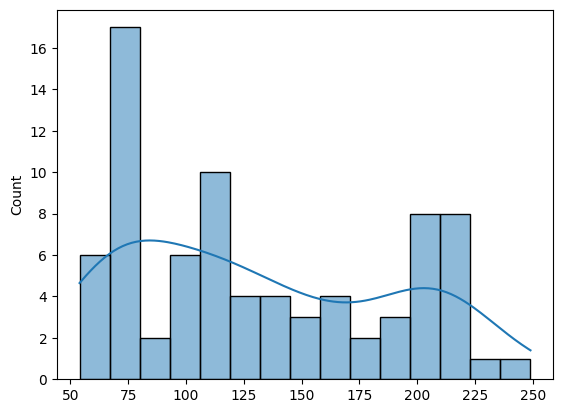

In [19]:
misclassified_len_dist = [len(sentence) for sentence in all_misclassified_sentences]
print(len(all_misclassified_sentences))
sns.histplot(misclassified_len_dist, kde=True, bins=15)
plt.show()